# Image Denoising

Acquired images are corrupted by noise. Noise are random variations that are due
the intrinsic quantic nature of light and thermal agitation of electrons in the 
circuits. 

Denoising is a fundamental problem in image processing as it requires to
model the nature of the image itself and therefore provided a good experimental
validation. Over the years many approaches have been proposed for
denoising images based on various assumption on the image.

## BM3D

BM3D is one of the most performant approach for method not actively based on 
learning.

Y. Mäkinen, L. Azzari, A. Foi, 2020, "Collaborative Filtering of Correlated Noise: Exact Transform-Domain Variance for Improved Shrinkage and Patch Matching", in IEEE Transactions on Image Processing, vol. 29, pp. 8339-8354.

We can install BM3D from pip
```
    pip install bm3d
```


Let's apply the denoising method on a test image

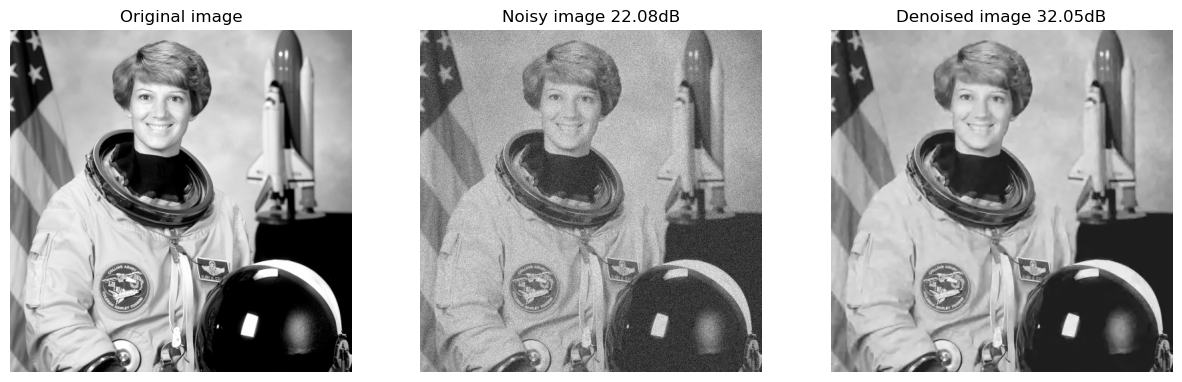

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from bm3d import bm3d
import skimage

def psnr(x, y, vmax = 255):
    """Peak signal to noise ratio quality metric"""
    import math
    return 10 * math.log10(vmax * vmax / np.mean(np.square(x - y)))

noise_std = 20
im = skimage.data.astronaut()[:,:,0]
noise = np.random.normal(0, noise_std, im.shape)
noisy = im.copy() + noise
denoised = bm3d(noisy, noise_std)

# display the result with quality metric
fig, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(im, cmap='gray')
ax[0].set_title('Original image')
ax[1].imshow(noisy, cmap='gray')
ax[1].set_title(f'Noisy image {psnr(noisy, im):.2f}dB')
ax[2].imshow(denoised, cmap='gray')
ax[2].set_title(f'Denoised image {psnr(denoised, im):.2f}dB')
for a in ax:
    a.set_axis_off()

In [68]:
def benchmark_denoising(method, imgpath):      
    import glob
    import pathlib    
    import pandas as pd 
    data = {'sigma' : [x for x in range(5,40,2)] }    
    for fname in sorted(glob.glob(imgpath)):
        name = pathlib.Path(fname).stem        
        data[name] = []
        img = skimage.io.imread(fname).astype(float)
        for noise_std in data['sigma']:        
            noisy = img + np.random.normal(0, noise_std, img.shape)
            denoised = method(noisy, noise_std)
            data[name].append(psnr(denoised, img))
    return pd.DataFrame(data)

result = benchmark_denoising(bm3d, '../data/Set12/*.png')

Text(0.5, 1.0, 'Set12 Benchmark')

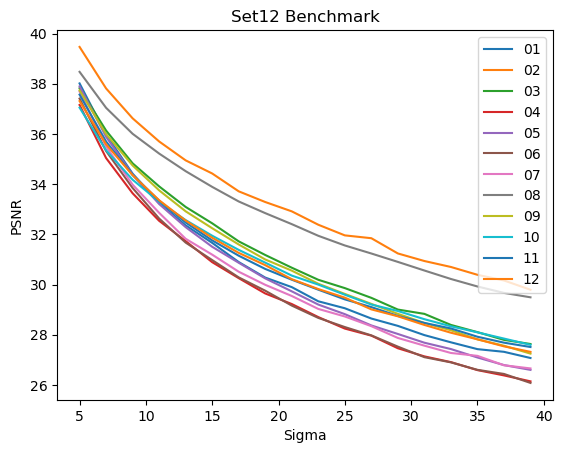

In [69]:
result.plot(x='sigma')
plt.xlabel('Sigma')
plt.ylabel('PSNR')
plt.title('Set12 Benchmark')

## DnCNN
In DnCNN the task is set to predict the the residual image between the noisy and
the noise free image. The network is composed of a deep (17 stage) sequence of 
blocks composed of convolution, batch normalization and RELU. The training is 
done by cropping 50x50 patches of images.

A supervised with known noise level and a blind version can be trained.

Zhang, Kai, et al. "Beyond a gaussian denoiser: Residual learning of deep cnn for 
image denoising." IEEE transactions on image processing 26.7 (2017): 3142-3155.

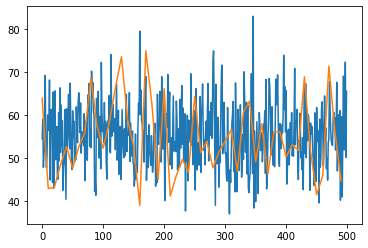

In [180]:
import glob
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms,datasets,io
import random
import matplotlib.pyplot as plt

class DnCNN(nn.Module):
    def __init__(self, depth=17):
        super(DnCNN, self).__init__()
        layers = []
        nf = 64
        layers.append(nn.Conv2d(in_channels=1,out_channels=nf,kernel_size=3,padding=1,bias=False))
        layers.append(nn.GELU(inplace=True))
        for _ in range(depth-2):
            layers.append(nn.Conv2d(in_channels=nf,out_channels=nf,kernel_size=3,padding=1,bias=False))
            layers.append(nn.BatchNorm2d(num_features=nf))
            layers.append(nn.GELU(inplace=True))
        layers.append(nn.Conv2d(in_channels=nf,out_channels=1,kernel_size=3,padding=1,bias=False))        
        self.net = nn.Sequential(*layers)

    def forward(self,x):
        return self.net(x)

class DnCNNDataset(Dataset):
    """load images from a folder"""
    def __init__(self, path, transform=None):
        super().__init__()   
        self.imagelist = [
            io.read_image(x, io.ImageReadMode.GRAY).squeeze()
            for x in glob.glob(path)
        ]                
        self.transform = transform
    def __len__(self):
        return len(self.imagelist)
    def __getitem__(self, idx):
        image = self.imagelist[idx]        
        return self.transform(image)
    
class DnCNNAugmenter(object):
    """Crop, flip, add noise and return a noisy and residual image"""
    def __init__(self, shape, noise_level):
        """Initialize the transform with shape and noise level
        shape : [H,W] dimension of the crop
        noise : noise level on which to train DnCNN
        """
        self.shape = shape
        self.noise_level = noise_level          
    def __call__(self, sample):
        """Apply the transform to the input"""             
        img = sample.clone().squeeze()        
        # random crops
        c = random.randint(0, img.shape[1] - self.shape[1])
        r = random.randint(0, img.shape[0] - self.shape[0])    
        img = img[r:r+self.shape[0],c:c+self.shape[1]] 
        # random flips                 
        for k in [0,1]:
            if random.random() > 0.5:
                img = torch.flip(img, [k])
        # random gamma [0.5,1.5]
        img = 255.0 * torch.pow(img / 255.0, 0.5+random.random())
        # reshape to tensor
        img = img.reshape([1,*self.shape])    
        # add noise
        residuals = self.noise_level * torch.randn(img.shape)                        
        noisy = img + residuals
        return noisy, residuals

def train(model,optimizer,loss_fn,train_dl,valid_dl,epochs=100,device='cpu'):
    """Training loops"""
    history = {
        'train_loss':[], 'train_epoch':[], 
        'valid_loss':[], 'valid_epoch':[] 
    }
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in train_dl:
            loss = loss_fn(model(batch[0].to(device)), batch[1].to(device))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.data.item()
            loss.detach()
        history['train_loss'].append(train_loss)
        history['train_epoch'].append(epoch)
        if epoch%10 == 0:
            model.eval()
            valid_loss = 0
            for batch in valid_dl:
                valid_loss += loss_fn(model(batch[0].to(device)), batch[1].to(device)).detach().item()
            history['valid_loss'].append(valid_loss)
            history['valid_epoch'].append(epoch)
    return history

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#model = DnCNN()
model.to(device)
train_dataset = DnCNNDataset('../data/Set12/*', DnCNNAugmenter([64,64], 20))
valid_dataset = DnCNNDataset('../data/Set12/*', DnCNNAugmenter([64,64], 20))
train_dl = DataLoader(train_dataset, batch_size=16)
valid_dl = DataLoader(valid_dataset, batch_size=16)
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()
history = train(model,optimizer,loss_fn,train_dl,valid_dl,500,device)
plt.plot(history['train_epoch'],history['train_loss'])
plt.plot(history['valid_epoch'],history['valid_loss'])


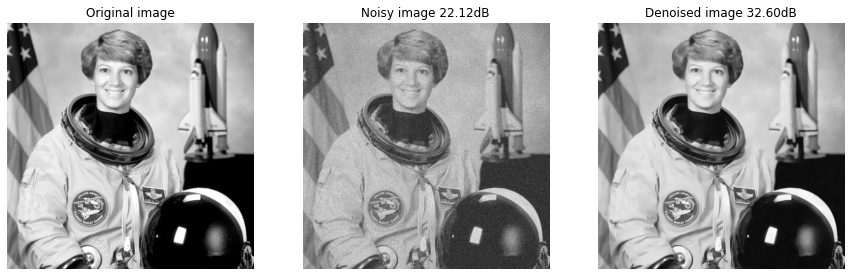

In [181]:
import skimage
import numpy as np

def psnr(x, y, vmax = 255):
    """Peak signal to noise ratio quality metric"""
    import math
    return 10 * math.log10(vmax * vmax / np.mean(np.square(x - y)))
    
noise_std = 20
im = skimage.data.astronaut()[:,:,0]
#im = skimage.io.imread('../data/Set12/08.png')
noise = np.random.normal(0, noise_std, im.shape)
noisy = im.copy() + noise
model.eval()
denoised = noisy - model(torch.from_numpy(noisy).float().reshape([1,1,*noisy.shape]).to(device)).detach().cpu().numpy().squeeze()

# display the result with quality metric
fig, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(im, cmap='gray')
ax[0].set_title('Original image')
ax[1].imshow(noisy, cmap='gray')
ax[1].set_title(f'Noisy image {psnr(noisy, im):.2f}dB')
ax[2].imshow(denoised, cmap='gray')
ax[2].set_title(f'Denoised image {psnr(denoised, im):.2f}dB')
for a in ax:
    a.set_axis_off()